In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib widget
from tqdm.notebook import tqdm
import functools as ft
import optax
import treex as tx
import sdf_jax
from sdf_jax.discretize import discretize3d
from sdf_jax.util import plot3d, plot2d

In [2]:
import trimesh

def load_mesh(path: str):
    """Loads a triangle mesh. Rescales to fit unit cube [0,1]^3."""
    mesh = trimesh.load(path)
    vertices = jnp.array(mesh.vertices)
    vertices -= vertices.min(axis=0)
    vertices /= vertices.max()
    faces = jnp.array(mesh.faces)
    return vertices, faces

def show_mesh(vertices, faces):
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    return mesh.show()

def show_points(vertices):
    colors = np.tile(np.array([0, 0, 0, 1]), (len(vertices), 1))
    p = trimesh.PointCloud(vertices, colors=colors)
    return p.scene().show()

vertices, faces = load_mesh("nefertiti.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/nefertiti.obj
# vertices, faces = load_mesh("spot.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/spot.obj
print("vertices:", vertices.shape)
print("faces:   ", faces.shape)
show_mesh(vertices, faces)

vertices: (49971, 3)
faces:    (99938, 3)


In [3]:
import functools as ft
from typing import Callable, List

def sample_normal_per_point(key, xs, local_sigma=0.01):
    key, key_local, key_global = jrandom.split(key, 3)
    sample_local = xs + jrandom.normal(key_local, xs.shape) * local_sigma
    sample_global = jrandom.uniform(key_global, (xs.shape[0]//8, xs.shape[1]))
    return jnp.vstack([sample_local, sample_global])

def surface_loss_fn(model, x):
    return jnp.abs(model(x))

def normal_loss_fn(model, x, normal):
    return 1.0 - jnp.dot(jax.grad(model)(x), normal)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, normals, lam, tau, key):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    if normals is not None:
        normal_loss = jnp.mean(jax.vmap(ft.partial(normal_loss_fn, model))(xs, normals))
    else:
        normal_loss = 0.0
    xs_eik = sample_normal_per_point(key, xs)
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + tau * normal_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, normals, lam, tau, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, normals, lam, tau, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

### GEOMETRY-CONSISTENT NEURAL SHAPE REPRESENTATION WITH IMPLICIT DISPLACEMENT FIELDS (Yifan et al, ICLR 2022)

In [7]:
from models import IGRModel, HashEmbedding, softplus
from models import IDFModel
from sdf_jax.util import dataloader

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.8f}")

def fit(
    xs,
    normals=None,
    lam=1.0,
    tau=1.0,
    # module
    hidden=64,
    act=softplus,
    emb_kwargs={"nmax": 32},
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    batch_size=128,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = IDFModel(
        IGRModel(input_dim=3, depth=7, hidden=hidden),
        tx.Sequential(
            HashEmbedding(),
            tx.Linear(64),
            softplus,
            tx.Linear(64),
            softplus,
            tx.Linear(1),
            lambda x: x[0]
        ),
        nu=0.05
    ).init(key=jrandom.PRNGKey(0), inputs=xs[0])

    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    key, data_key = jrandom.split(key, 2)
    for step, (xs_batch, normals_batch) in zip(tqdm(range(steps)), dataloader(xs, normals, batch_size, key=data_key)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs_batch, normals_batch, lam, tau, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(42)
xs = vertices
print(xs.shape)
loss, model = fit(xs, steps=100, cb_every=10, batch_size=1024, act=softplus, hidden=512, lam=0.1, emb_kwargs={"nmax": 8}, key=key)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

(49971, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.21816418
[10] loss: 0.20661023
[20] loss: 0.09001832
[30] loss: 0.05129024
[40] loss: 0.18150824
[50] loss: 0.04257797
[60] loss: 0.03291826
[70] loss: 0.03146601
[80] loss: 0.02415217
[90] loss: 0.02272487
[99] loss: 0.04745344


In [ ]:
func = lambda x: model(jnp.array([0.3, x[0], x[1]]))

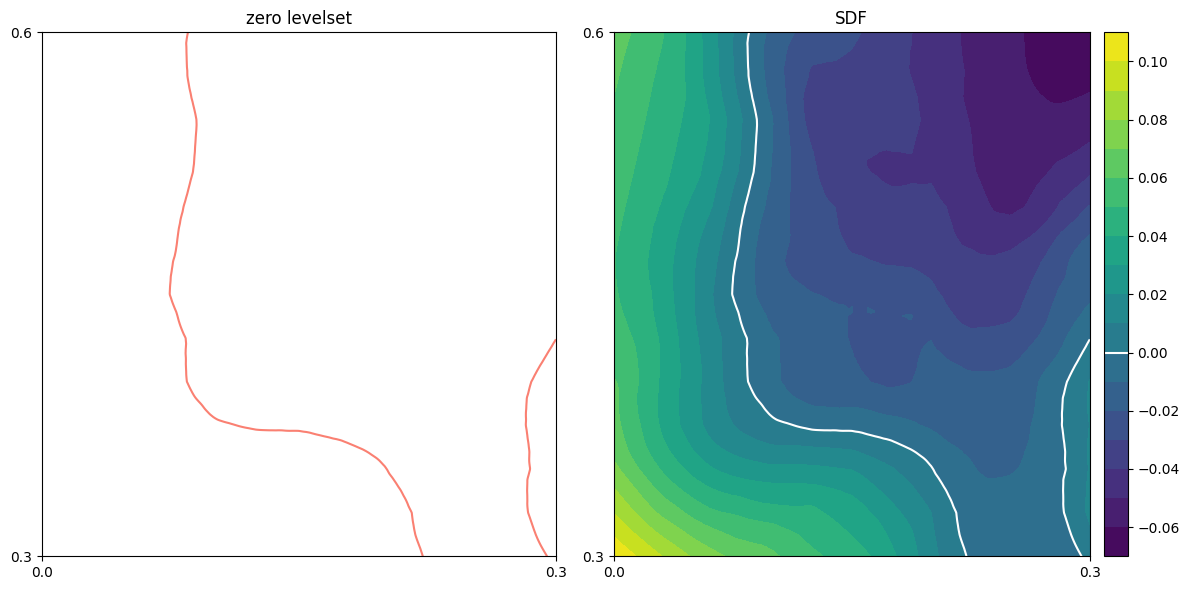

In [41]:
plot2d(func, x_lims=(0.0, 0.3), y_lims=(0.3, 0.6), ngrid=400, figsize=(12,6))

# Sphere tracing

In [ ]:
def raymarch(sdf, position, direction, maxiter):
    # ray marching by sphere tracing
    def march(position_t, t):
        position_next = position_t + sdf(position_t) * direction
        return position_next, position_next
    t = jnp.arange(maxiter)
    position_final, trajectory = lax.scan(march, position, t, length=maxiter)
    return position_final
    
def make_xy_grid(height, width):
    grid2d = jnp.stack(jnp.meshgrid(jnp.linspace(0, 1, width), jnp.linspace(0, 1, height)))
    grid = jnp.concatenate([grid2d, jnp.zeros((1, height, width))])
    grid = jnp.moveaxis(grid, 0, -1)
    return grid

def render_projection(sdf, height, width):
    direction = jnp.array([0., 0., 1.])
    trace = jax.jit(jax.vmap(jax.vmap(lambda x: raymarch(sdf, x, direction, 10))))
    grid = make_xy_grid(height, width)
    results = trace(grid)
    results = jnp.minimum(results, 1.0) # clamp
    plt.matshow(results[:,:,2])

render_projection(model, 100, 100)